# Transer Learning - Fine Tuning

Following up from the last notebook, this one is continuing the path of Transfer Learning for the task of classifying faces as wearing masks or not. The last notebook went over the quick and powerful method of feature extraction, but in the case where the results aren't sufficiently accurate, the method of fine tuning can be used.

Similiar to before, the VGG16 Convulution Nueral Network Architecture pretrained on ImageNet was used as the source model. The final Fully Connected (FC) layers at the end are removed, exposing the output of the model to be the (7 * 7 * 512) vector. 

From here, a new model is made using the output of the headless VGG16 as the input of this model. In this project the new "head" is a single FC layer (following a dropout layer) leading to a dense softmax classification layer.

Below some more details will be discuss, but please acknowledge that this project was guided/inspired heavily by this [Pyimagesearch.com blog post](https://www.pyimagesearch.com/2019/06/03/fine-tuning-with-keras-and-deep-learning/)

In [16]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from imutils import paths
import pandas as pd
import numpy as np
import pickle
import random
import os
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report





# Variable Constants #
ORIG_INPUT_DATASET = "mask-classifier-images"
BASE_PATH = "dataset"

TRAIN = "training"
TEST = "evaluation"
VAL = "validation"

CLASSES = ["Mask", "No_Mask"]

LE_PATH = os.path.sep.join(["output", "le.cpickle"])
BASE_CSV_PATH = "output"

MODEL_PATH = os.path.sep.join(["output", "maskclassifier.model"])

BATCH_SIZE = 32

# define the path to the output training history plots
UNFROZEN_PLOT_PATH = os.path.sep.join(["output", "unfrozen.png"])
WARMUP_PLOT_PATH = os.path.sep.join(["output", "warmup.png"])

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

This function was provided by Pyimagesearch blog post. It plots the results of the training metrics (i.e. loss and accuracy)

In [3]:
def plot_training(H, N, plotPath):
    # construct a plot that plots and saves the training history
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig(plotPath)

Below the paths for the training, validation, and test data are declared

In [6]:
trainPath = os.path.sep.join([ORIG_INPUT_DATASET, BASE_PATH, TRAIN])
valPath = os.path.sep.join([ORIG_INPUT_DATASET, BASE_PATH, VAL])
testPath = os.path.sep.join([ORIG_INPUT_DATASET, BASE_PATH, TEST])

# determine the total number of image paths in training, validation,
# and testing directories
totalTrain = len(list(paths.list_images(trainPath)))
totalVal = len(list(paths.list_images(valPath)))
totalTest = len(list(paths.list_images(testPath)))

The next cell creates an ImagaDataGenerator, a class to preform data augmentation, the techniques of altering images to create larger robust training data. This function also generates the augmentated data in real time when the training batch is produced. Parameters were chosen according to the suggestions from Pyimagesearch.

In [4]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")
# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()
# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

In [11]:
# initialize the training generator
trainGen = trainAug.flow_from_directory(
    trainPath,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=True,
    batch_size=BATCH_SIZE)
# initialize the validation generator
valGen = valAug.flow_from_directory(
    valPath,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=False,
    batch_size=BATCH_SIZE)
# initialize the testing generator
testGen = valAug.flow_from_directory(
    testPath,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=False,
    batch_size=BATCH_SIZE)

Found 6763 images belonging to 2 classes.
Found 1691 images belonging to 2 classes.
Found 2114 images belonging to 2 classes.


In the cell below, the base model is loaded in headless, exposing the (7 * 7 * 512) output layer. The new model is built using the base model's output as the new model's input. Then the last line "stitches" the two models together into one full model

In [14]:
#load VGG16 pretrained on imagenet with its top removed
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

#contruct the new model head
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(CLASSES), activation="softmax")(headModel)

#this next line "stitches" the new head to the topless VGG16 pretrained model
model = Model(inputs=baseModel.input, outputs=headModel)

When fine tuning, the goal is to leverage what was already learned in the pretrained model while training the new head, and to avoid losing things learning in those layers, they will be frozen while training.

In [15]:
#this lines freezes the pretrained layers by looping through them
for layer in baseModel.layers:
    layer.trainable = False

The model is compliled using Stocatic Gradient Decent. The model is then fit using 50 epochs, and it took about 11 hours to train using the GTX 1080 graphics card. Afterwards, the testing data was used to evaluate the results, and a plot was made of the loss, accuracy, validation loss and validation accuracy.

In [19]:
print("[INFO] compiling model...")
opt = SGD(lr=1e-4, momentum=0.9)
model.compile(loss = "categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

#train model while base model is fozen
H = model.fit(x=trainGen,
              steps_per_epoch=totalTrain // BATCH_SIZE,
              validation_data=valGen,
             validation_steps= totalVal // BATCH_SIZE,
             epochs=50)
#reset testing generator and evaluate results
print("[INFO] evaluating after fine-tuning network head...")
testGen.reset()
predIdxs = model.predict(x=testGen,
                         steps = (totalTest // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testGen.classes, predIdxs, target_names=testGen.class_indices.keys()))
plot_training(H, 50, WARMUP_PLOT_PATH)

[INFO] compiling model...
Epoch 1/50
211/211 [==============================] - 791s 4s/step - loss: 1.2669 - accuracy: 0.7005 - val_loss: 0.3996 - val_accuracy: 0.8341
Epoch 2/50
211/211 [==============================] - 784s 4s/step - loss: 0.5385 - accuracy: 0.7712 - val_loss: 0.3440 - val_accuracy: 0.8654
Epoch 3/50
211/211 [==============================] - 767s 4s/step - loss: 0.4733 - accuracy: 0.7856 - val_loss: 0.3262 - val_accuracy: 0.8672
Epoch 4/50
211/211 [==============================] - 779s 4s/step - loss: 0.4303 - accuracy: 0.8110 - val_loss: 0.3283 - val_accuracy: 0.8702
Epoch 5/50
211/211 [==============================] - 812s 4s/step - loss: 0.4144 - accuracy: 0.8150 - val_loss: 0.2898 - val_accuracy: 0.8762
Epoch 6/50
211/211 [==============================] - 808s 4s/step - loss: 0.4037 - accuracy: 0.8217 - val_loss: 0.2772 - val_accuracy: 0.8870
Epoch 7/50
211/211 [==============================] - 792s 4s/step - loss: 0.3931 - accuracy: 0.8287 - val_loss: 0.3

NameError: name 'preIdxs' is not defined

              precision    recall  f1-score   support

        Mask       0.92      0.89      0.90       861
     No_Mask       0.92      0.95      0.93      1253

    accuracy                           0.92      2114
   macro avg       0.92      0.92      0.92      2114
weighted avg       0.92      0.92      0.92      2114



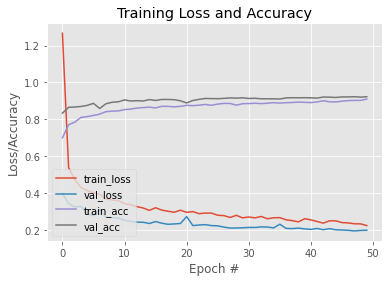

In [20]:
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testGen.classes, predIdxs, target_names=testGen.class_indices.keys()))
plot_training(H, 50, WARMUP_PLOT_PATH)

Looking at the classification report, the results are actually a bit worse than that of feature extraction, despite taking the 11 hours to train. However, more can be done. From here the last layer from the base mode can be unfrozen and retrained for a shorter amount of time. This creates a better synergy between the old and new models' layers

In [21]:
# reset our data generators
trainGen.reset()
valGen.reset()

#unfreeze CONV layers from base model
for layer in baseModel.layers[15:]:
    layer.trainable=True
    
for layer in baseModel.layers:
    print("{}: {}".format(layer, layer.trainable))

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x0000022547A9CC18>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000022547AA97B8>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000022547AA99E8>: False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x0000022547AA9DD8>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000022547ABCA20>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000022547B05828>: False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x0000022547B05780>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000022547B0D390>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000022547B0DEF0>: False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000022547B1F438>: False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x0000022547B1FD30>: False
<tensorf

In [22]:
print("[INFO] re-compiling model...")
opt = SGD(lr=1e-4, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

H = model.fit(x=trainGen,
              steps_per_epoch=totalTrain // BATCH_SIZE,
              validation_data=valGen,
              validation_steps=totalVal // BATCH_SIZE,
              epochs=20)

[INFO] re-compiling model...
Epoch 1/20
211/211 [==============================] - 909s 4s/step - loss: 0.2134 - accuracy: 0.9118 - val_loss: 0.1518 - val_accuracy: 0.9411
Epoch 2/20
211/211 [==============================] - 906s 4s/step - loss: 0.1576 - accuracy: 0.9375 - val_loss: 0.1344 - val_accuracy: 0.9525
Epoch 3/20
211/211 [==============================] - 907s 4s/step - loss: 0.1393 - accuracy: 0.9458 - val_loss: 0.1298 - val_accuracy: 0.9585
Epoch 4/20
211/211 [==============================] - 908s 4s/step - loss: 0.1236 - accuracy: 0.9550 - val_loss: 0.1084 - val_accuracy: 0.9621
Epoch 5/20
211/211 [==============================] - 902s 4s/step - loss: 0.1147 - accuracy: 0.9580 - val_loss: 0.1596 - val_accuracy: 0.9423
Epoch 6/20
211/211 [==============================] - 900s 4s/step - loss: 0.1043 - accuracy: 0.9608 - val_loss: 0.0970 - val_accuracy: 0.9675
Epoch 7/20
211/211 [==============================] - 900s 4s/step - loss: 0.1008 - accuracy: 0.9609 - val_loss: 

[INFO] evaluating after fine-tunning network...
              precision    recall  f1-score   support

        Mask       0.97      0.97      0.97       861
     No_Mask       0.98      0.98      0.98      1253

    accuracy                           0.98      2114
   macro avg       0.98      0.98      0.98      2114
weighted avg       0.98      0.98      0.98      2114

[INFO] serializing network...


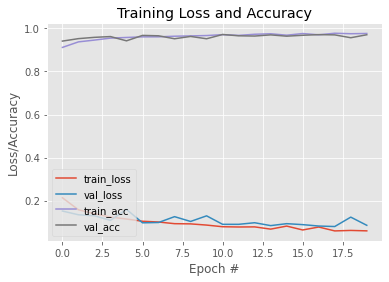

In [24]:
print("[INFO] evaluating after fine-tunning network...")
testGen.reset()
predIdxs = model.predict(x=testGen,
                         steps=(totalTest // BATCH_SIZE) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testGen.classes, predIdxs, target_names=testGen.class_indices.keys()))

plot_training(H, 20, UNFROZEN_PLOT_PATH)

# serialize the model to disk
print("[INFO] serializing network...")
model.save(MODEL_PATH, save_format="h5")

The results after this second line of training actually fine tuned the model to beat the feature extraction results, showing it definetly made a difference. Since the results were so good, the model was saved in .h5 format.